In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['font.size'] = 14
cities_label = {"London":"london", 
                "New York":"newyork", 
                "Beijing":"beijing",
                "Hong Kong":"hongkong",
                "Singapore":"singapore"}

In [2]:
def reward(P_ac, P_heat, tbuild):
    w=0.1
    P_ac = P_ac/3.6/0.43
    P_heat = P_heat/0.9/0.96
    r = -w*1*(P_ac + P_heat) - (1-w)*1*(abs(tbuild - 24 - 273.15) + abs(tbuild - 18 - 273.15))
    return r

In [3]:
def cal_reward(ds_rl, timeslice=("2012", "2013")):
    ds_rl['reward'] = reward(ds_rl['URBAN_AC'].isel(landunit=1), ds_rl['URBAN_HEAT'].isel(landunit=1), ds_rl['TBUILD'].isel(landunit=1))
    return ds_rl['reward'].sel(time=slice(*timeslice)).mean().values, ds_rl['reward'].sel(time=slice(*timeslice)).std().values

In [4]:
df = pd.DataFrame(columns=["city", "mean", "std", "type"])
df_dict = {}

for city in cities_label:
    if city == "London":
        timeslice = ("2012", "2012")
    else:
        timeslice = ("2021", "2021")
    default_file = f"../hac_on_wasteheat/{cities_label[city]}/default.nc"
    rl_file = f"../clmu_sac_output/{cities_label[city]}_sac_clmu_sac.nc"
    ds = xr.open_dataset(default_file)
    ds_rl = xr.open_dataset(rl_file)
    mean, std = cal_reward(ds, timeslice)
    df = pd.concat([df, pd.DataFrame({"model":["Default"], "city":[city], "mean":[mean], "std":[std], "type":["Default"]})])
    mean, std = cal_reward(ds_rl, timeslice)
    df = pd.concat([df, pd.DataFrame({"model":[city], "city":[city], "mean":[mean], "std":[std], "type":[f"{city} to {city}" ]})])
    
    for c in cities_label:
        
        if c != city:
            
            rl_ts_file = f"../clmu_sac_output/{cities_label[c]}_to_{cities_label[city]}_clmu_sac.nc"
            ds_rl_ts = xr.open_dataset(rl_ts_file)
            
            mean, std = cal_reward(ds_rl_ts, timeslice)
            df = pd.concat([df, pd.DataFrame({"model":[c], "city":[city], "mean":[mean], "std":[std], "type":[f"{c} to {city}"]})])

df

,city,mean,std,type,model
0,London,-7.490558,1.2195758,Default,Default
0,London,-6.5304375,1.2076737,London to London,London
0,London,-6.415626,0.7045554,New York to London,New York
0,London,-7.3480773,1.897887,Beijing to London,Beijing
0,London,-6.419711,0.72515666,Hong Kong to London,Hong Kong
0,London,-9.667375,3.8821886,Singapore to London,Singapore
0,New York,-8.842535,2.6912062,Default,Default
0,New York,-7.4896555,1.6290826,New York to New York,New York
0,New York,-8.370146,3.196013,London to New York,London
0,New York,-7.944302,2.1567843,Beijing to New York,Beijing


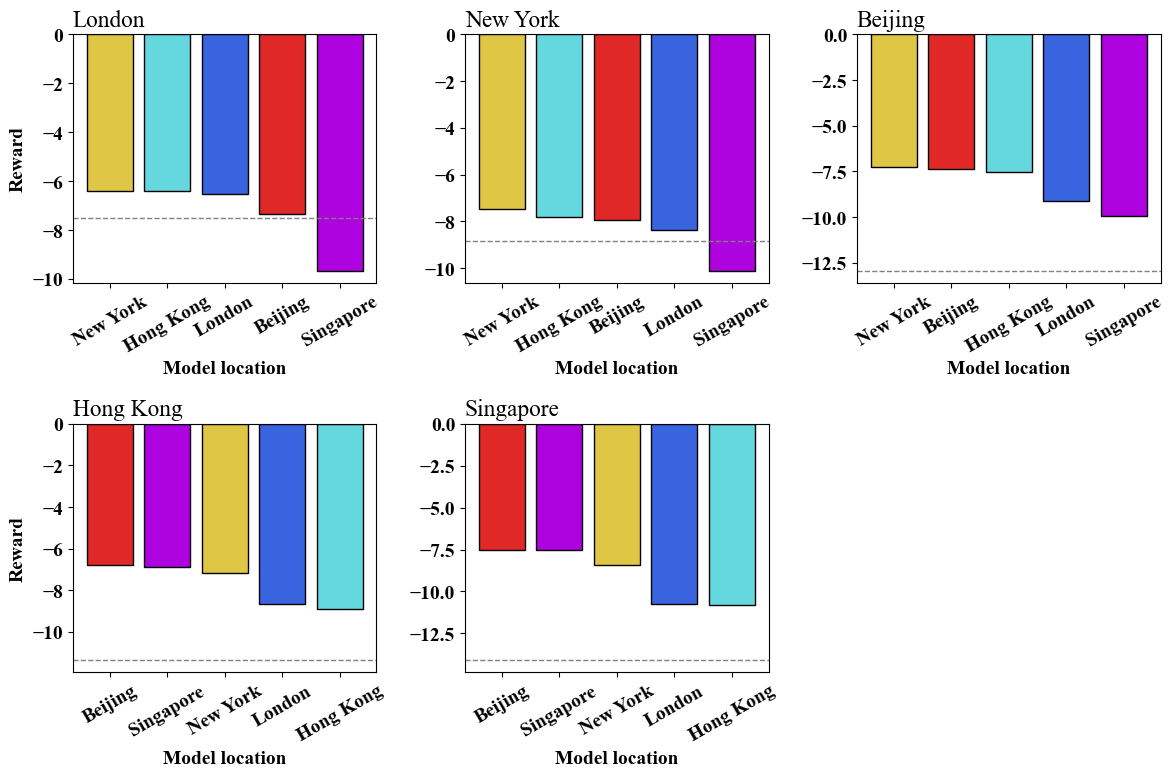

In [5]:
fig = plt.figure(figsize=(12, 8))

colors = ['#0091FF','#da4167','#ff70a6','#ff9770','#ffcd70','#ff70a6','#ff9770','#ffcd70']

colors = ["#3964DF", "#E0C645","#E02927",  "#65D8DF", "#AE02DE"]
cities = ["London", "New York", "Beijing", "Hong Kong", "Singapore"]

cities_colors = dict(zip(cities, colors))

df['color'] = df['model'].map(cities_colors)

rank_sore = df[df['model'] == "Default"].groupby('model')['mean'].mean().sort_values(ascending=False).index

i = 1
for c in df['city'].unique():
    ax = fig.add_subplot(2, 3, i)
    df_plot = df[df['city'] == c]
    vline = ax.axhline(df_plot['mean'].iloc[0], color='gray', linewidth=1, linestyle='--', label='Default')
    df_plot = df_plot[df_plot['model'] != "Default"].sort_values(by='mean', ascending=False)
    
    x = np.arange(len(df_plot['model'].unique()))
    
    rects = ax.bar(x, df_plot['mean'], #yerr=df_plot['std'], 
                    label=c, width=0.8, 
                    color=df_plot['color'],
                    edgecolor='black')
    ax.set_xticks(x)
    ax.set_xlabel('Model location')
    ax.set_xticklabels(df_plot['model'].unique(), rotation=30)
    ax.set_title(c, loc='left')
    
    if i in [1, 4]:
        ax.set_ylabel('Reward')
    
    i += 1

plt.tight_layout()
fig.savefig("./figs/transfer.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
forcing = pd.read_csv("./forcing.csv")[["city", "type", "Tair"]]
forcing_m = forcing[forcing['type'] == "mean"]
forcing_s = forcing[forcing['type'] == "std"]
forcing = pd.merge(forcing_m, forcing_s, on="city", suffixes=('_mean', '_std'))
forcing

,city,type_mean,Tair_mean,type_std,Tair_std
0,London,mean,284.496370,std,5.435870
1,New York,mean,286.432095,std,9.491790
2,Beijing,mean,286.095572,std,11.497437
3,Hong Kong,mean,296.917605,std,5.360631
4,Singapore,mean,300.163381,std,1.345017


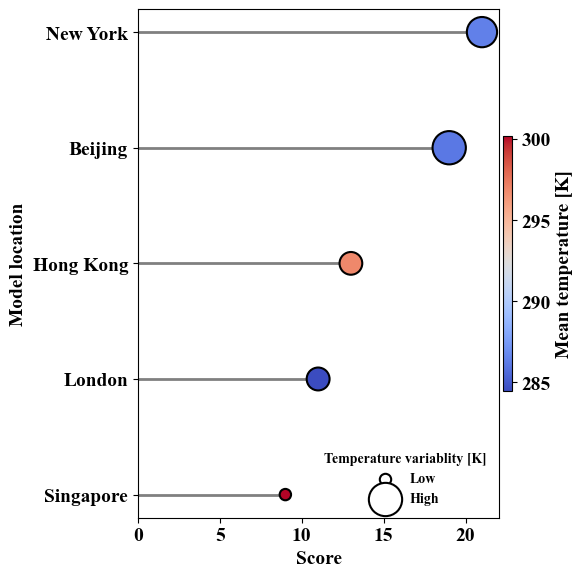

In [7]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)

# prepare rank
rank = pd.DataFrame(columns=["city", "model", "index"])
for city in cities:
    df_city = df[df['city'] == city]
    df_city = df_city.sort_values(by="mean", ascending=True).reset_index(drop=True).reset_index()
    rank = pd.concat([rank, df_city[['index','model','city']]])

rank = rank.groupby("model").sum().reset_index().sort_values(by="index")
rank = pd.merge(rank, forcing, left_on="model", right_on="city")

rank_plot = rank[rank['model'] != "Default"]
rank_plot['color'] = rank_plot['model'].map(cities_colors)

ax.hlines(y=rank['model'], xmin=0, xmax=rank['index'], color='gray', linewidth=2, zorder=1)
ax.set_xlim(0)

sc = ax.scatter(rank_plot['index'], 
                rank_plot['model'], 
                c=rank_plot['Tair_mean'], 
                cmap='coolwarm', 
                s=rank_plot['Tair_std']*50,
                edgecolor='black',
                linewidth=1.5,)
cbar = plt.colorbar(sc, pad=0.01, aspect=30, shrink=0.5)
cbar.set_label('Mean temperature [K]')

sizes = [min(rank_plot['Tair_std']*50), max(rank_plot['Tair_std']*50)]
labels = ["Low", "High"]
handles = [plt.scatter([], [], s=s, color='white', edgecolor='black', linewidth=1.5) for s in sizes]
ax.legend(handles, labels, title="Temperature variablity [K]", loc='lower right', frameon=False, 
          fontsize=10, title_fontsize=10, labelspacing=0.5)

#rank_plot.plot.bar(x="model", y="index", color=rank_plot['color'], 
#                   linewidth=1, edgecolor='black',
#                   ax=ax, 
#                   legend=False)
#ax.set_xticklabels(rank_plot['model'], rotation=30)
ax.set_xlabel("Score")
ax.set_ylabel("Model location")

plt.tight_layout()
plt.savefig("./figs/transfer_rank.pdf", dpi=300, bbox_inches='tight')
plt.show()